In [1]:
import pandas as pd
import numpy as np
import arviz as az

import kinesis as kn
import gapipes as gp

In [2]:
model = kn.AnisotropicDisperion()

INFO:kinesis.models:Reading model from disk


In [3]:
out_full = pd.read_csv("../data/hyades_full.csv")
# %store -r out_full
df = out_full.loc[out_full['in_dr2'] == True]
print(f'{len(df)} rows')

515 rows


In [5]:
df= df.iloc[::5].reset_index(drop=True)

In [4]:
N=len(df)
truth_T0 = dict(
    b0=[17.7, 41.2, 13.3], v0=np.array([-6.32, 45.24, 5.30]), sigmav=0.3
)

## Isotropic case

In [5]:
cl = kn.Cluster(**truth_T0).sample_at(df.g.icrs).observe(cov=df.g.make_cov())

data = cl.members.observed.copy()
# attach simulated radial velocities only to stars with RV observed
data = cl.members.observed.copy()
irv = np.where(df["radial_velocity"].notnull())[0]
data.loc[irv, "radial_velocity"] = np.random.normal(
    cl.members.truth["radial_velocity"].values[irv],
    scale=df["radial_velocity_error"].values[irv],
)
data.loc[irv, "radial_velocity_error"] = df.loc[irv, "radial_velocity_error"]

In [6]:
cl

Cluster(b0=[17.7, 41.2, 13.3], v0=[-6.32, 45.24, 5.3], sigmav=0.3)

In [7]:
def init_func():
    return dict(
        d=1e3 / data["parallax"].values,
        sigv=[1.5, 1.5, 1.5],
        v0=[17,40,13],
        Omega=np.eye(3),
    )
fit = model.fit(data, sample=False, init=init_func)

In [8]:
fit['sigv'], fit['Omega']

(array([0.3084491 , 0.31231202, 0.28033184]),
 array([[ 1.        ,  0.13199966, -0.10529266],
        [ 0.13199966,  1.        , -0.37799364],
        [-0.10529266, -0.37799364,  1.        ]]))

In [9]:
%%time
print(len(data['ra']))
fit = model.fit(data, init=init_func)

515


CPU times: user 809 ms, sys: 1.14 s, total: 1.95 s
Wall time: 2min 36s


In [10]:
azfit = az.from_pystan(fit)

In [11]:
az.summary(azfit, )

/data/vault/soh/projects/opensource/arviz/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.313,0.019,-6.349,-6.278,0.000,0.000,2278.0,2278.0,2280.0,2685.0,1.0
v0[1],45.234,0.033,45.172,45.293,0.001,0.001,2077.0,2077.0,2078.0,2535.0,1.0
v0[2],5.295,0.017,5.264,5.328,0.000,0.000,2574.0,2574.0,2575.0,2673.0,1.0
sigv[0],0.317,0.027,0.266,0.366,0.001,0.001,1242.0,1242.0,1273.0,1337.0,1.0
sigv[1],0.325,0.042,0.245,0.401,0.001,0.001,1732.0,1732.0,1757.0,2005.0,1.0
sigv[2],0.286,0.022,0.245,0.327,0.001,0.000,1240.0,1240.0,1230.0,1840.0,1.0
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",0.021,0.178,-0.330,0.336,0.005,0.003,1320.0,1305.0,1369.0,1398.0,1.0
"Omega[0,2]",-0.087,0.117,-0.314,0.124,0.003,0.002,1167.0,1137.0,1191.0,1298.0,1.0
"Omega[1,0]",0.021,0.178,-0.330,0.336,0.005,0.003,1320.0,1305.0,1369.0,1398.0,1.0


In [12]:
np.allclose(azfit.posterior.Omega.stack(
    sample=['chain','draw']).values[[0,1,2],[0,1,2],:], 1)

True

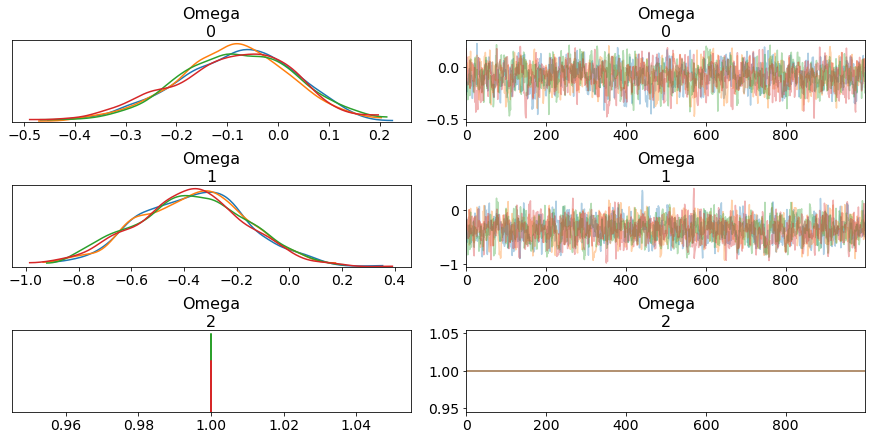

In [13]:
az.plot_trace(azfit, var_names='Omega', coords={'Omega_dim_0':2, 'Omega_dim_1':[0,1,2]});

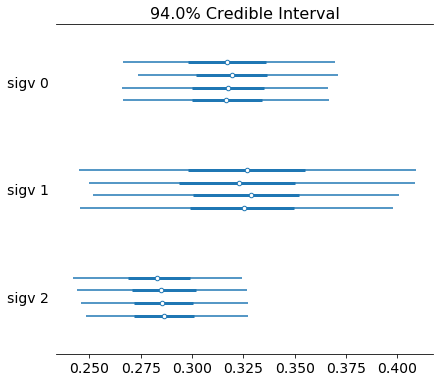

In [15]:
az.plot_forest(azfit, var_names=['sigv']);

## Anisotropic case

In [63]:
cl = kn.Cluster(
    b0=[17.7, 41.2, 13.3], v0=[-6.32, 45.24, 5.3], sigmav=[0.3, 1., 0.3]).sample_at(df.g.icrs).observe(cov=df.g.make_cov())

data = cl.members.observed.copy()
# attach simulated radial velocities only to stars with RV observed
data = cl.members.observed.copy()
irv = np.where(df["radial_velocity"].notnull())[0]
data.loc[irv, "radial_velocity"] = np.random.normal(
    cl.members.truth["radial_velocity"].values[irv],
    scale=df["radial_velocity_error"].values[irv],
)
data.loc[irv, "radial_velocity_error"] = df.loc[irv, "radial_velocity_error"]

In [64]:
cl

Cluster(b0=[17.7, 41.2, 13.3], v0=[-6.32, 45.24, 5.3], sigmav=[0.3, 1.0, 0.3])

In [65]:
def init_func():
    return dict(
        d=1e3 / data["parallax"].values,
        sigv=[1.5, 1.5, 1.5],
        v0=[17,40,13],
        Omega=np.eye(3),
    )
fit = model.fit(data, sample=False, init=init_func)

In [66]:
fit['sigv'], fit['Omega']

(array([0.30783054, 0.9822253 , 0.31339274]),
 array([[1.        , 0.06350252, 0.14156876],
        [0.06350252, 1.        , 0.08637262],
        [0.14156876, 0.08637262, 1.        ]]))

In [67]:
%%time
print(len(data['ra']))
fit = model.fit(data, init=init_func)

515


CPU times: user 845 ms, sys: 1.3 s, total: 2.14 s
Wall time: 2min 49s


In [68]:
azfit = az.from_pystan(fit)

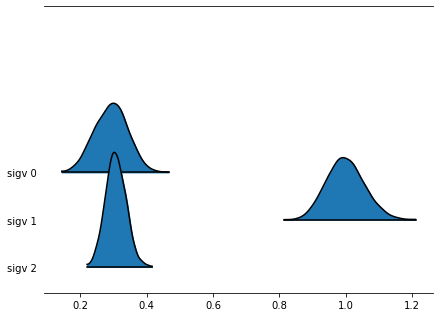

In [69]:
az.plot_forest(azfit, var_names=['sigv'], combined=True, kind='ridgeplot');

In [70]:
az.summary(azfit, )

/data/vault/soh/projects/opensource/arviz/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.327,0.029,-6.382,-6.272,0.001,0.001,1025.0,1025.0,1026.0,1819.0,1.00
v0[1],45.217,0.065,45.090,45.331,0.002,0.001,1073.0,1073.0,1074.0,2010.0,1.00
v0[2],5.306,0.025,5.260,5.353,0.001,0.001,1023.0,1023.0,1024.0,2079.0,1.00
sigv[0],0.292,0.049,0.203,0.386,0.002,0.001,758.0,751.0,764.0,1045.0,1.00
sigv[1],0.999,0.055,0.895,1.102,0.001,0.001,2410.0,2399.0,2426.0,2805.0,1.00
sigv[2],0.307,0.030,0.251,0.365,0.001,0.001,954.0,954.0,939.0,1518.0,1.00
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",-0.056,0.165,-0.378,0.226,0.006,0.004,688.0,688.0,719.0,1034.0,1.01
"Omega[0,2]",0.015,0.229,-0.415,0.432,0.009,0.007,590.0,590.0,626.0,820.0,1.01
"Omega[1,0]",-0.056,0.165,-0.378,0.226,0.006,0.004,688.0,688.0,719.0,1034.0,1.01


(<Figure size 432x352.8 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f679b6bc0f0>],
       dtype=object))

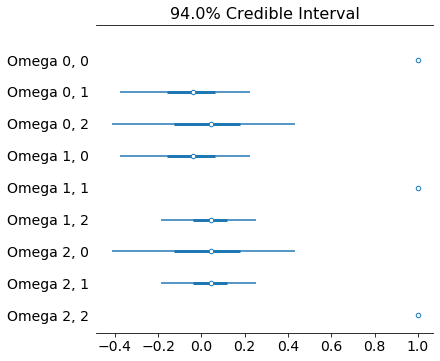

In [71]:
az.plot_forest(azfit, var_names=['Omega'], combined=True)